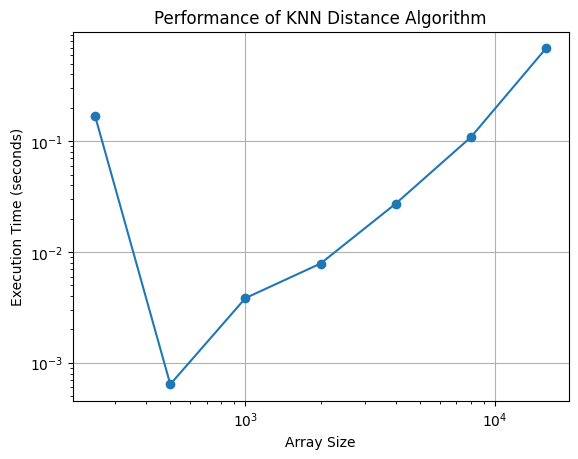

In [1]:
import numpy as np
import cupy as cp
import time
import matplotlib.pyplot as plt

distance_ = cp.RawKernel(
    r'''
    // CUDA kernel function for computing Euclidean distance between vectors
    extern "C" __global__
    void kernel(const float* inp_a,          // Input array A
                const float* inp_b,          // Input array B
                float* outp,                // Output array for distances
                const int n, const int m, const int k) {  // Sizes of arrays and dimensions
        // Calculate the thread's position within the grid
        int grid_x = blockDim.x * blockIdx.x + threadIdx.x;  // Calculate x position within the grid
        int grid_y = blockDim.y * blockIdx.y + threadIdx.y;  // Calculate y position within the grid
        
        // Calculate the index of the current element in the output array
        int grid_xy = grid_x + grid_y * n;
        
        // Check if the current thread is within the valid range of elements to process
        if (grid_x < n && grid_y < m) {
            // Initialize distance accumulator
            float dist = 0;
            // Compute Euclidean distance between corresponding elements of inp_a and inp_b
            for (int i = 0; i < k; i++) {
                const float d = (inp_a[grid_x * k + i] - inp_b[grid_y * k + i]);  // Compute difference
                dist += (d * d);  // Square the difference and accumulate
            }
            outp[grid_xy] = dist;  // Store squared Euclidean distance in the output array
        }
    }
    ''', 
    "kernel"  # Name of the kernel function
)


def distance(inp_a: np.ndarray, inp_b: np.ndarray) -> np.ndarray:
    """
    Calculates the pairwise euclidean distance between two given arrays on CUDA. 
    Handles HtD and DtH transfers itself.
    """
    n, k_ = inp_a.shape
    m, k = inp_b.shape
    assert k_ == k

    inp_a = inp_a.astype('float32')
    inp_b = inp_b.astype('float32')
    outp = cp.zeros((n, m), dtype=cp.float32)


    # We choose max block size (1024) just because that's what cool guys (and girls) do B-)
    block_size_x, block_size_y = 32, 32
    # Calculate how many blocks would cover the full array
    grid_size_x = (n + block_size_x - 1) // block_size_x
    grid_size_y = (m + block_size_y - 1) // block_size_y

    inp_a = cp.asarray(inp_a, dtype=cp.float32)
    inp_b = cp.asarray(inp_b, dtype=cp.float32)
    
    distance_( 
        (grid_size_x, grid_size_y),
        (block_size_x, block_size_y),
        (
            inp_a, inp_b,
            outp, 
            cp.int32(n), cp.int32(m), cp.int32(k)
        )
    )
    
    outp = cp.sqrt(outp)  # Take square root after copying back to host1
    return np.array(outp.get())

# Define array sizes for testing
array_sizes = [250, 500, 1000, 2000, 4000, 8000, 16000]

# Measure execution time for each array size
execution_times = []
for size in array_sizes:
    inp_a = np.random.randn(size, 10).astype('float32')
    inp_b = np.random.randn(size, 10).astype('float32')
    
    start_time = time.time()
    out = distance(inp_a, inp_b)
    end_time = time.time()
    
    execution_time = end_time - start_time
    execution_times.append(execution_time)

# Plotting
plt.loglog(array_sizes, execution_times, marker='o')
plt.title('Performance of KNN Distance Algorithm')
plt.xlabel('Array Size')
plt.ylabel('Execution Time (seconds)')
plt.grid(True)
plt.show()

# Inspect data

In [2]:
! head data.csv

0.233449,0.166667,0.381818,0.424594,0.164110,0.354839,0.250000,0.325581,0.166184,0.192771,6.000000
0.160279,0.196078,0.263636,0.262181,0.176380,0.161290,0.346154,0.255814,0.196453,0.301205,5.000000
0.083624,0.156863,0.300000,0.396752,0.191718,0.177419,0.355769,0.360465,0.226141,0.186747,6.000000
0.097561,0.107843,0.390909,0.201856,0.019939,0.451613,0.288462,0.372093,0.088490,0.216867,7.000000
0.073171,0.411765,0.445455,0.271462,0.007669,0.467742,0.413462,0.232558,0.128976,0.283133,5.000000
0.111498,0.235294,0.454545,0.197216,0.062883,0.822581,0.201923,0.406977,0.048775,0.168675,7.000000
0.024390,0.107843,0.309091,0.213457,0.015337,0.500000,0.442308,0.500000,0.132832,0.253012,4.000000
0.118467,0.127451,0.363636,0.262181,0.151840,0.419355,0.326923,0.209302,0.147869,0.186747,6.000000
0.108014,0.225490,0.290909,0.248260,0.185583,0.387097,0.298077,0.500000,0.159823,0.198795,6.000000
0.149826,0.137255,0.445455,0.357309,0.214724,0.096774,0.403846,0.546512,0.254290,0.253012,7.000000


## Parse data

In [3]:
import pandas as pd

df = pd.read_csv('data.csv', header=None)
df.columns = [ f'feat{i:1d}' for i in range(10) ] + ['label']
# df = df.convert_dtypes()
df.label = df.label.astype(int)
df

,feat0,feat1,feat2,feat3,feat4,feat5,feat6,feat7,feat8,feat9,label
0,0.233449,0.166667,0.381818,0.424594,0.164110,0.354839,0.250000,0.325581,0.166184,0.192771,6
1,0.160279,0.196078,0.263636,0.262181,0.176380,0.161290,0.346154,0.255814,0.196453,0.301205,5
2,0.083624,0.156863,0.300000,0.396752,0.191718,0.177419,0.355769,0.360465,0.226141,0.186747,6
3,0.097561,0.107843,0.390909,0.201856,0.019939,0.451613,0.288462,0.372093,0.088490,0.216867,7
4,0.073171,0.411765,0.445455,0.271462,0.007669,0.467742,0.413462,0.232558,0.128976,0.283133,5
...,...,...,...,...,...,...,...,...,...,...,...
3995,0.216028,0.098039,0.372727,0.415313,0.141104,0.419355,0.288462,0.337209,0.155966,0.144578,6
3996,0.202091,0.147059,0.400000,0.375870,0.243865,0.177419,0.317308,0.430233,0.229227,0.210843,6
3997,0.111498,0.156863,0.727273,0.278422,0.087423,0.387097,0.211538,0.220930,0.144399,0.192771,5
3998,0.052265,0.215686,0.463636,0.292343,0.058282,0.677419,0.250000,0.255814,0.103913,0.162651,6


In [4]:
df.isna().any().any()

False

In [5]:
df.describe()

,feat0,feat1,feat2,feat3,feat4,feat5,feat6,feat7,feat8,feat9,label
count,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000
mean,0.116510,0.195335,0.425750,0.300546,0.089198,0.406244,0.293487,0.312828,0.133438,0.200724,5.882000
std,0.059493,0.099523,0.136702,0.098385,0.078084,0.199519,0.080470,0.132579,0.058018,0.072472,0.893463
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.000000
25%,0.073171,0.127451,0.327273,0.232019,0.016871,0.241935,0.240385,0.220930,0.088876,0.156627,5.000000
50%,0.111498,0.176471,0.418182,0.290023,0.070552,0.387097,0.288462,0.290698,0.128976,0.186747,6.000000
75%,0.153310,0.235294,0.509091,0.366589,0.142638,0.548387,0.336538,0.383721,0.173318,0.230422,6.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,0.975807,0.663462,1.000000,1.000000,0.740964,9.000000


<Axes: ylabel='Frequency'>

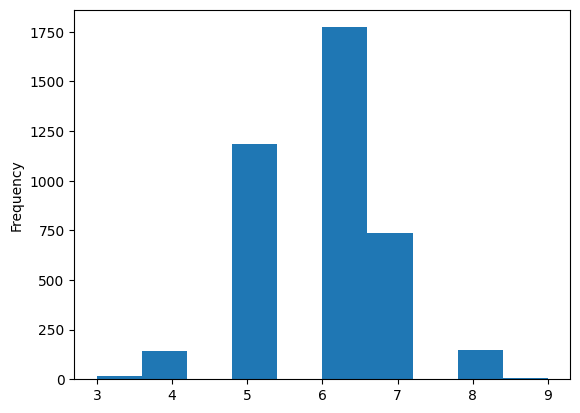

In [6]:
df.label.plot.hist(bins=10)

In [7]:
df.label.value_counts()

label
6    1773
5    1185
7     735
8     147
4     140
3      16
9       4
Name: count, dtype: int64

In [8]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

              precision    recall  f1-score   support

           3       0.00      0.00      0.00         3
           4       0.36      0.29      0.32        28
           5       0.64      0.58      0.61       237
           6       0.65      0.68      0.66       355
           7       0.53      0.59      0.56       147
           8       0.42      0.48      0.45        29
           9       0.00      0.00      0.00         1

    accuracy                           0.61       800
   macro avg       0.37      0.37      0.37       800
weighted avg       0.61      0.61      0.61       800



/home/tornikeo/micromamba/envs/pb2/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/tornikeo/micromamba/envs/pb2/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/tornikeo/micromamba/envs/pb2/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitaliz

In [9]:
x, y = df.drop(columns='label').to_numpy(), df.label.to_numpy()
x, y

(array([[0.233449, 0.166667, 0.381818, ..., 0.325581, 0.166184, 0.192771],
        [0.160279, 0.196078, 0.263636, ..., 0.255814, 0.196453, 0.301205],
        [0.083624, 0.156863, 0.3     , ..., 0.360465, 0.226141, 0.186747],
        ...,
        [0.111498, 0.156863, 0.727273, ..., 0.22093 , 0.144399, 0.192771],
        [0.052265, 0.215686, 0.463636, ..., 0.255814, 0.103913, 0.162651],
        [0.216028, 0.176471, 0.427273, ..., 0.186047, 0.164064, 0.23494 ]]),
 array([6, 5, 6, ..., 5, 6, 6]))

In [13]:
from collections import Counter
from sklearn.base import BaseEstimator
from scipy import stats

class CuKNN(BaseEstimator):
    """
    Perform kNN learning on GPU, using a custom CUDA kernel, written in
    CuPy's RawKernel. This class extends scikit-learn's base estimator
    class to conform to usual .fit and .predict mechanics.
    """
    def __init__(self, n_neighbors:int=5) -> None:
        super().__init__()
        self.n_neighbors = n_neighbors

    def fit(self, x, y):
        self.x = cp.array(x)
        self.y = cp.array(y)
        return self
    
    def predict(self, x):
        x # Shape N, F
        self.x # Shape M, F
        # distances shape of N, M, d[i, j] = euclidean_norm(x[i, ...] - self.x[j, ...])
        
        dist = distance(self.x, x) # size N, M
        k_idx = np.argsort(dist)[:self.n_neighbors] # size N, n_neigh
        k_labels = self.y[k_idx].T.get() # size N, n_neigh
        assert k_labels.shape[1] == self.n_neighbors
        return stats.mode(k_labels, axis=1, keepdims=False).mode
        

knn = CuKNN(n_neighbors=1)
train, val = train_test_split(df, stratify=df.label, random_state=42, test_size=.2)
train_x, train_y = train.drop(columns='label'), train['label']
val_x, val_y = val.drop(columns='label'), val['label']

knn.fit(train_x, train_y)
val_pred = knn.predict(val_x)
# print(val_pred.shape, val_y.shape)
print(classification_report(val_y, val_pred))

              precision    recall  f1-score   support

           3       0.00      0.00      0.00         3
           4       0.06      0.07      0.07        28
           5       0.30      0.28      0.29       237
           6       0.43      0.44      0.44       355
           7       0.16      0.16      0.16       147
           8       0.00      0.00      0.00        29
           9       0.00      0.00      0.00         1

    accuracy                           0.31       800
   macro avg       0.14      0.14      0.14       800
weighted avg       0.31      0.31      0.31       800

